# IBM Applied Data Science Capstone Course by Coursera
### Week 5 Final Report
**_Opening a New Eatery in Bangalore, India_**
- Build a dataframe of neighborhoods in Bangalore, India by web scraping the data from Wikipedia page
- Get the geographical coordinates of the neighborhoods
- Obtain the venue data for the neighborhoods from Foursquare API
- Explore and cluster the neighborhoods
- Select the best cluster to open a new shopping mall
***
### 1. Import libraries

In [80]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print("Libraries imported.")

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


### 2. Scrap data from Wikipedia page into a DataFrame

In [198]:
# send the GET request
data = requests.get("https://commons.wikimedia.org/wiki/Category:Suburbs_of_Bangalore").text

In [202]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [203]:
# create a list to store neighborhood data
neighborhoodList = []
soup



<!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>Category:Suburbs of Bangalore - Wikimedia Commons</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"XrkGVwpAMNMAAZkgcWYAAAAR","wgCSPNonce":!1,"wgCanonicalNamespace":"Category","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":14,"wgPageName":"Category:Suburbs_of_Bangalore","wgTitle":"Suburbs of Bangalore","wgCurRevisionId":381561717,"wgRevisionId":381561717,"wgArticleId":7490535,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Uses of Wikidata Infobox","Bangalore","Suburbs in India","Suburbs in Karnataka","Geography of Bangalore","Populated places 

In [204]:
# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
        neighborhoodList.append(row.text)
neighborhoodList


['►  Agara, Bangalore\u200e (2 C,  6 F)',
 '►  Arekere\u200e (5 F)',
 '►  Banashankari\u200e (1 C,  5 F)',
 '►  Banaswadi\u200e (2 F)',
 '►  Basavanagudi\u200e (5 C,  11 F)',
 '►  Begur, Bangalore\u200e (1 C,  6 F)',
 '►  Bellandur\u200e (1 C,  4 F)',
 '►  BEML\u200e (7 F)',
 '►  Bengaluru Pete\u200e (9 C,  4 F)',
 '►  Bidadi\u200e (2 C,  2 F)',
 '►  Bommasandra\u200e (33 F)',
 '►  Brigade Road, Bangalore\u200e (3 C,  8 F)',
 '►  Chandapura\u200e (4 F)',
 '►  Devanahalli\u200e (5 C,  2 F)',
 '►  Dhobi Ghat (Bangalore)\u200e (3 F)',
 '►  Domlur\u200e (5 C,  23 F)',
 '►  Electronics City\u200e (2 C,  34 F)',
 '►  Fraser Town, Bangalore\u200e (1 C,  10 F)',
 '►  Girinagar\u200e (1 C,  11 F)',
 '►  HBR Layout\u200e (1 C,  1 F)',
 '►  Hebbal\u200e (2 C,  3 F)',
 '►  Hosakote\u200e (1 C)',
 '►  HSR Layout\u200e (1 C,  12 F)',
 '►  Indiranagar\u200e (4 C,  8 F)',
 '►  Ittamadu\u200e (3 F)',
 '►  J. P. Nagar\u200e (2 C,  1 F)',
 '►  Jakkur\u200e (2 C,  1 F)',
 '►  Jayanagar, Bangalore\u200e (1

In [205]:
# create a new DataFrame from the list
kl_df = pd.DataFrame({"Neighborhood": neighborhoodList})

for column in kl_df.columns:
    kl_df[column] = kl_df[column].str.replace(r"\(.*\)", "")
    kl_df[column] = kl_df[column].str.replace(r"\[.*\]", "")
    kl_df[column] = kl_df[column].str.replace(r", Bangalore", "")
    kl_df[column] = kl_df[column].str.replace(r"►", "")
#remove duplicate rows
kl_df.drop_duplicates(subset="Neighborhood", inplace=True)

kl_df.head()

Neighborhood
0           Agara‎ 
1         Arekere‎ 
2    Banashankari‎ 
3       Banaswadi‎ 
4    Basavanagudi‎

In [206]:
# print the number of rows of the dataframe
kl_df.shape

(59, 1)

### 3. Get the geographical coordinates

In [87]:
address = 'Bangalore, India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore City are 12.9791198, 77.5912997.


In [207]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates

    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Bangalore, India'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [208]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in kl_df["Neighborhood"].tolist() ]

In [209]:
coords

[[12.842830000000049, 77.48759000000007],
 [12.885680000000036, 77.59668000000005],
 [12.87341248765075, 77.53801254302039],
 [13.019643510687336, 77.65469211693214],
 [12.938980000000072, 77.57137000000006],
 [12.882450000000063, 77.62475000000006],
 [12.927350000000047, 77.67185000000006],
 [12.964900000000057, 77.59240000000005],
 [12.966180000000065, 77.58690000000007],
 [12.966180000000065, 77.58690000000007],
 [12.817530000000033, 77.67879000000005],
 [12.966235877087087, 77.6067910877087],
 [12.794010000000071, 77.70015000000006],
 [13.250110000000063, 77.70788000000005],
 [12.966180000000065, 77.58690000000007],
 [12.943290000000047, 77.65602000000007],
 [12.839884329698537, 77.67221065989045],
 [12.998940000000061, 77.61276000000004],
 [12.947163401610013, 77.55479203719199],
 [13.044134286483883, 77.62689253546107],
 [13.049810000000036, 77.58903000000004],
 [13.077180000000055, 77.80178000000006],
 [12.910368572854768, 77.64930070191588],
 [12.978220000000022, 77.63397000000

In [210]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [211]:
# merge the coordinates into the original dataframe
kl_df['Latitude'] = df_coords['Latitude']
kl_df['Longitude'] = df_coords['Longitude']

In [212]:
# check the neighborhoods and the coordinates
print(kl_df.shape)
kl_df

(59, 3)


Neighborhood   Latitude  Longitude
0                    Agara‎   12.842830  77.487590
1                  Arekere‎   12.885680  77.596680
2             Banashankari‎   12.873412  77.538013
3                Banaswadi‎   13.019644  77.654692
4             Basavanagudi‎   12.938980  77.571370
5                    Begur‎   12.882450  77.624750
6                Bellandur‎   12.927350  77.671850
7                     BEML‎   12.964900  77.592400
8           Bengaluru Pete‎   12.966180  77.586900
9                   Bidadi‎   12.966180  77.586900
10             Bommasandra‎   12.817530  77.678790
11            Brigade Road‎   12.966236  77.606791
12              Chandapura‎   12.794010  77.700150
13             Devanahalli‎   13.250110  77.707880
14               Dhobi Ghat   12.966180  77.586900
15                  Domlur‎   12.943290  77.656020
16        Electronics City‎   12.839884  77.672211
17             Fraser Town‎   12.998940  77.612760
18               Girinagar‎   12.947163  77.554792
19              HBR Layout‎   13.044134  77.626893
20                  Hebbal‎   13.049810  77.589030
21                Hosakote‎   13.077180  77.801780
22              HSR Layout‎   12.910369  77.649301
23             Indiranagar‎   12.978220  77.633970
24                Ittamadu‎   12.923440  77.542840
25             J. P. Nagar‎   12.908310  77.590240
26                  Jakkur‎   13.075640  77.603940
27               Jayanagar‎   12.928720  77.582810
28       Jeevanbheemanagar‎   12.967560  77.655700
29              Kettohalli‎   12.966180  77.586900
30               Kodihalli‎   12.966200  77.649820
31             Konanakunte‎   12.882330  77.569260
32             Koramangala‎   12.920040  77.625460
33         Krishnarajapura‎   13.000390  77.683680
34            Kundalahalli‎   12.967520  77.715000
35                Madiwala‎   12.920520  77.620900
36                  Magadi‎   12.986273  77.488591
37            Mahadevapura‎   12.994090  77.666330
38                 Majestic   12.977590  77.572560
39             Malleswaram‎   13.006322  77.568416
40            Marathahalli‎   12.954660  77.707520
41               Mathikere‎   13.032350  77.558660
42           Murugeshpalya‎   12.955650  77.653350
43              Nagarbhavi‎   12.956240  77.509360
44             Rajajinagar‎   13.011920  77.547170
45    Rajarajeshwari Nagar‎   12.931780  77.526680
46        Ramamurthy Nagar‎   13.023820  77.677850
47          Sahakara Nagar‎   13.061103  77.574092
48          Seetharampalya‎   13.113200  77.424630
49            Shivajinagar‎   12.987200  77.604010
50            Thubarahalli‎   12.953500  77.721140
51             Tippasandra‎   12.971710  77.647800
52                 UB City‎   12.971370  77.595820
53                  Ulsoor‎   12.989080  77.627950
54                 Varthur‎   12.943480  77.747030
55              Whitefield‎   12.975230  77.752380
56               Yelahanka‎   13.099310  77.592590
57             Yeshwantpur‎   13.039120  77.577970
58             Yeswanthpur‎   13.018644  77.557617

In [213]:
# save the DataFrame as CSV file
kl_df.to_csv("kl_df.csv", index=False)

### 4. Create a map of Bangalore with neighborhoods superimposed on top

In [214]:
# get the coordinates of Bangalore
address = 'Bangalore, India'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore, India {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore, India 12.9791198, 77.5912997.


In [215]:
# create map of Toronto using latitude and longitude values
map_kl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(kl_df['Latitude'], kl_df['Longitude'], kl_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_kl)  
    
map_kl

In [216]:
# save the map as HTML file
map_kl.save('map_kl.html')

### 5. Use the Foursquare API to explore the neighborhoods

In [217]:
# define Foursquare Credentials and Version
CLIENT_ID = 'A2VC5XGM0A0G3EUICIQTHSN4KKKX14QLG2DQKSZ5AHBSIYVR' # your Foursquare ID
CLIENT_SECRET = 'X2IBNGDICER2NWFOGW0VGKD3DPWBWG3SQPWC5UG32OHGC1BQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A2VC5XGM0A0G3EUICIQTHSN4KKKX14QLG2DQKSZ5AHBSIYVR
CLIENT_SECRET:X2IBNGDICER2NWFOGW0VGKD3DPWBWG3SQPWC5UG32OHGC1BQ


**Now, let's get the top 100 venues that are within a radius of 2000 meters.**

In [222]:
radius = 2000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(kl_df['Latitude'], kl_df['Longitude'], kl_df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [223]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(3575, 7)


Neighborhood  Latitude  Longitude                       VenueName  \
0    Arekere‎   12.88568   77.59668  Decathlon Sports India Pvt Ltd   
1    Arekere‎   12.88568   77.59668               Natural Ice Cream   
2    Arekere‎   12.88568   77.59668                        Swensens   
3    Arekere‎   12.88568   77.59668                       Cinepolis   
4    Arekere‎   12.88568   77.59668                         Chavadi   

   VenueLatitude  VenueLongitude        VenueCategory  
0      12.887513       77.597712  Sporting Goods Shop  
1      12.892188       77.598222       Ice Cream Shop  
2      12.876071       77.595542       Ice Cream Shop  
3      12.876119       77.595455            Multiplex  
4      12.892199       77.602538            BBQ Joint

In [224]:
map_display = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
for lat, lng, neighborhood in zip(venues_df['VenueLatitude'], venues_df['VenueLongitude'], venues_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1.5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_display)  
    
map_display

**Let's check how many venues were returned for each neighorhood**

In [225]:
venues_df.groupby(["Neighborhood"]).count()

Latitude  Longitude  VenueName  VenueLatitude  \
Neighborhood                                                              
  Arekere‎                      76         76         76             76   
  BEML‎                        100        100        100            100   
  Banashankari‎                  8          8          8              8   
  Banaswadi‎                    49         49         49             49   
  Basavanagudi‎                100        100        100            100   
  Begur‎                        16         16         16             16   
  Bellandur‎                    88         88         88             88   
  Bengaluru Pete‎              100        100        100            100   
  Bidadi‎                      100        100        100            100   
  Bommasandra‎                   7          7          7              7   
  Brigade Road‎                100        100        100            100   
  Chandapura‎                    4          4          4              4   
  Devanahalli‎                   6          6          6              6   
  Dhobi Ghat                   100        100        100            100   
  Domlur‎                       52         52         52             52   
  Electronics City‎             42         42         42             42   
  Fraser Town‎                  97         97         97             97   
  Girinagar‎                    60         60         60             60   
  HBR Layout‎                   17         17         17             17   
  HSR Layout‎                   53         53         53             53   
  Hebbal‎                       42         42         42             42   
  Hosakote‎                      6          6          6              6   
  Indiranagar‎                 100        100        100            100   
  Ittamadu‎                     40         40         40             40   
  J. P. Nagar‎                 100        100        100            100   
  Jakkur‎                       11         11         11             11   
  Jayanagar‎                   100        100        100            100   
  Jeevanbheemanagar‎           100        100        100            100   
  Kettohalli‎                  100        100        100            100   
  Kodihalli‎                   100        100        100            100   
  Konanakunte‎                  13         13         13             13   
  Koramangala‎                 100        100        100            100   
  Krishnarajapura‎              69         69         69             69   
  Kundalahalli‎                 84         84         84             84   
  Madiwala‎                    100        100        100            100   
  Magadi‎                        7          7          7              7   
  Mahadevapura‎                 46         46         46             46   
  Majestic                     100        100        100            100   
  Malleswaram‎                 100        100        100            100   
  Marathahalli‎                 72         72         72             72   
  Mathikere‎                    64         64         64             64   
  Murugeshpalya‎                80         80         80             80   
  Nagarbhavi‎                   13         13         13             13   
  Rajajinagar‎                  75         75         75             75   
  Rajarajeshwari Nagar‎         35         35         35             35   
  Ramamurthy Nagar‎              8          8          8              8   
  Sahakara Nagar‎               32         32         32             32   
  Shivajinagar‎                100        100        100            100   
  Thubarahalli‎                 44         44         44             44   
  Tippasandra‎                 100        100        100            100   
  UB City‎                     100        100        100            100   
  Ulsoor‎                      100        100      

**Let's find out how many unique categories can be curated from all the returned venues**

In [226]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 209 uniques categories.


In [227]:
# print out the list of categories
venues_df['VenueCategory'].unique()[:50]

array(['Sporting Goods Shop', 'Ice Cream Shop', 'Multiplex', 'BBQ Joint',
       'South Indian Restaurant', 'Lounge', 'Indian Restaurant',
       'Beer Garden', 'Bowling Alley', 'Café', 'Pizza Place', 'Brewery',
       'Restaurant', 'Chinese Restaurant', 'Liquor Store', 'Office',
       'Sandwich Place', 'Shopping Mall', 'Fast Food Restaurant',
       'Department Store', 'Eastern European Restaurant',
       'Middle Eastern Restaurant', 'American Restaurant',
       'General Entertainment', 'Burger Joint', 'Coffee Shop',
       'Rajasthani Restaurant', 'Italian Restaurant', 'Supermarket',
       'Dive Bar', 'Dumpling Restaurant', 'Clothing Store',
       'Electronics Store', 'Dessert Shop', 'Boutique', 'Food Court',
       'Movie Theater', 'Cosmetics Shop', 'Vegetarian / Vegan Restaurant',
       'Breakfast Spot', 'Bakery', 'Cafeteria',
       'Multicuisine Indian Restaurant', 'Pharmacy', 'Trail', 'Bistro',
       'Pub', 'Korean Restaurant', 'Falafel Restaurant',
       'Andhra Restaur

In [228]:
to_replace=np.array(['Ice Cream Shop', 'BBQ Joint',
       'South Indian Restaurant','Indian Restaurant',
       'Beer Garden', 'Café', 'Pizza Place', 'Brewery',
       'Restaurant', 'Chinese Restaurant', 'Sandwich Place','Fast Food Restaurant', 'Eastern European Restaurant',
       'Middle Eastern Restaurant', 'American Restaurant',
        'Burger Joint', 'Coffee Shop',
       'Rajasthani Restaurant', 'Italian Restaurant',
       'Dive Bar', 'Dumpling Restaurant','Breakfast Spot', 'Diner','Food Court','Vegetarian / Vegan Restaurant',
       'Asian Restaurant', 'Bistro', 'Pub', 'Korean Restaurant',
       'Falafel Restaurant','Andhra Restaurant','Donut Shop',
       'Indian Chinese Restaurant', 'Snack Place', 'Kerala Restaurant',
        'Seafood Restaurant',
       'Dessert Shop', 'Szechuan Restaurant', 'Juice Bar', 'Food Truck',
        'Salad Place','Hookah Bar','North Indian Restaurant', 'Bar', 'Hotel',
       'Afghan Restaurant', 'Punjabi Restaurant', 'Japanese Restaurant', 'Hotel Bar',
      'Mediterranean Restaurant', 'Fried Chicken Joint', 'Sushi Restaurant', 'Deli / Bodega',
       'French Restaurant', 'Bed & Breakfast', 'Cupcake Shop','Cocktail Bar',
       'Wine Bar', 'Bubble Tea Shop','Bagel Shop',
       'Tea Room', 'Health Food Store','Mexican Restaurant',
       'Karnataka Restaurant', 'Steakhouse',
       'Cafeteria', 'Food','Bakery',
       'Hyderabadi Restaurant', 'Pakistani Restaurant','Candy Store',
        'Indian Sweet Shop',
       'Kebab Restaurant', 'Chettinad Restaurant',
       'Maharashtrian Restaurant', 'Bengali Restaurant',
       'German Restaurant',  'Chocolate Shop',
       'Vietnamese Restaurant', 'Burrito Place', 'Nightclub', 'Multicuisine Indian Restaurant', 'Modern European Restaurant',
       'Thai Restaurant', 'Tex-Mex Restaurant','Dhaba', 'Udupi Restaurant',
       'Irish Pub', 'Dim Sum Restaurant',
       'Gastropub', 'Creperie','Noodle House', 'Food & Drink Shop', 'Chaat Place', 'Caribbean Restaurant', 'Turkish Restaurant'])

In [229]:
venues_df['VenueCategory']=venues_df['VenueCategory'].replace(dict.fromkeys((to_replace), 'Eatery'))

In [230]:
# check if the results contain "Eatery"
"Eatery" in venues_df['VenueCategory'].unique()

True

In [231]:
venues_df['VenueCategory'].unique()

array(['Sporting Goods Shop', 'Eatery', 'Multiplex', 'Lounge',
       'Bowling Alley', 'Liquor Store', 'Office', 'Shopping Mall',
       'Department Store', 'General Entertainment', 'Supermarket',
       'Clothing Store', 'Electronics Store', 'Boutique', 'Movie Theater',
       'Cosmetics Shop', 'Pharmacy', 'Trail', 'Arts & Crafts Store',
       'Gym', 'Music Venue', 'Athletics & Sports', 'Park',
       'Shop & Service', 'Bookstore', 'Farmers Market', 'Jewelry Store',
       'Art Gallery', 'Salon / Barbershop', 'Pool', 'Historic Site',
       "Women's Store", 'Arcade', 'Auto Garage', 'Bus Station', 'Lake',
       'Soccer Field', 'Sports Bar', 'Grocery Store', 'Moving Target',
       'Badminton Court', 'Recreation Center', 'Other Great Outdoors',
       'Bike Shop', 'Business Service', 'Gym / Fitness Center',
       'Furniture / Home Store', 'Theater', 'Cricket Ground', 'Plaza',
       'Hockey Arena', 'Toy / Game Store', 'Botanical Garden',
       'Music Store', 'Track Stadium', 'Spa', 

### 6. Analyze Each Neighborhood

In [232]:
# one hot encoding
kl_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kl_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kl_onehot.columns[-1]] + list(kl_onehot.columns[:-1])
kl_onehot = kl_onehot[fixed_columns]

print(kl_onehot.shape)
kl_onehot.tail()

(3575, 115)


Neighborhoods  ATM  Accessories Store  Airport  Arcade  Art Gallery  \
3570    Yeswanthpur‎     0                  0        0       0            0   
3571    Yeswanthpur‎     0                  0        0       0            0   
3572    Yeswanthpur‎     0                  0        0       0            0   
3573    Yeswanthpur‎     0                  0        0       0            0   
3574    Yeswanthpur‎     0                  0        0       0            0   

      Art Museum  Arts & Crafts Store  Athletics & Sports  Auto Garage  \
3570           0                    0                   0            0   
3571           0                    0                   0            0   
3572           0                    0                   0            0   
3573           0                    0                   0            0   
3574           0                    0                   0            0   

      Auto Workshop  Badminton Court  Basketball Court  Big Box Store  \
3570              0                0                 0              0   
3571              0                0                 0              0   
3572              0                0                 0              0   
3573              0                0                 0              0   
3574              0                0                 0              0   

      Bike Shop  Boarding House  Bookstore  Botanical Garden  Boutique  \
3570          0               0          0                 0         0   
3571          0               0          0                 0         0   
3572          0               0          0                 0         0   
3573          0               0          0                 0         0   
3574          0               0          0                 0         0   

      Bowling Alley  Bridge  Building  Bus Line  Bus Station  Bus Stop  \
3570              0       0         0         0            0         0   
3571              0       0         0         0            0         0   
3572              0       0         0         0            0         0   
3573              0       0         0         0            0         0   
3574              0       0         0         0            0         0   

      Business Service  Butcher  Capitol Building  Clothing Store  \
3570                 0        0                 0               0   
3571                 0        0                 0               0   
3572                 0        0                 0               0   
3573                 0        0                 0               0   
3574                 0        0                 0               0   

      Concert Hall  Convenience Store  Cosmetics Shop  Coworking Space  \
3570             0                  0               0                0   
3571             0                  0               0                0   
3572             0                  0               0                0   
3573             0                  0               0                0   
3574             0                  0               0                0   

      Cricket Ground  Department Store  Eatery  Electronics Store  \
3570               0                 0       0                  0   
3571               0                 0       1                  0   
3572               0                 0       1                  0   
3573               0                 0       1                  0   
3574               0                 0       1                  0   

      Event Space  Farmers Market  Financial or Legal Service  \
3570            0               0                           0   
3571            0               0                           0   
3572            0               0                           0   
3573            0               0                           0   
3574            0               0                           0   

      Fish & Chips Shop  Flea Market  Furniture / Home Store  Gaming Cafe  \
3570            

**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [296]:
kl_grouped = kl_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(kl_grouped.shape)
kl_grouped

(57, 115)


Neighborhoods       ATM  Accessories Store   Airport    Arcade  \
0                  Arekere‎   0.000000             0.0000  0.000000  0.000000   
1                     BEML‎   0.000000             0.0000  0.000000  0.010000   
2             Banashankari‎   0.000000             0.0000  0.000000  0.000000   
3                Banaswadi‎   0.000000             0.0000  0.000000  0.000000   
4             Basavanagudi‎   0.000000             0.0000  0.000000  0.010000   
5                    Begur‎   0.000000             0.0000  0.000000  0.000000   
6                Bellandur‎   0.000000             0.0000  0.000000  0.000000   
7           Bengaluru Pete‎   0.000000             0.0000  0.000000  0.010000   
8                   Bidadi‎   0.000000             0.0000  0.000000  0.010000   
9              Bommasandra‎   0.000000             0.0000  0.000000  0.000000   
10            Brigade Road‎   0.000000             0.0000  0.000000  0.000000   
11              Chandapura‎   0.000000             0.0000  0.000000  0.000000   
12             Devanahalli‎   0.000000             0.0000  0.000000  0.000000   
13               Dhobi Ghat   0.000000             0.0000  0.000000  0.010000   
14                  Domlur‎   0.000000             0.0000  0.000000  0.019231   
15        Electronics City‎   0.000000             0.0000  0.000000  0.000000   
16             Fraser Town‎   0.000000             0.0000  0.000000  0.000000   
17               Girinagar‎   0.000000             0.0000  0.000000  0.000000   
18              HBR Layout‎   0.000000             0.0000  0.000000  0.000000   
19              HSR Layout‎   0.000000             0.0000  0.000000  0.000000   
20                  Hebbal‎   0.000000             0.0000  0.000000  0.000000   
21                Hosakote‎   0.000000             0.0000  0.000000  0.000000   
22             Indiranagar‎   0.000000             0.0000  0.000000  0.010000   
23                Ittamadu‎   0.000000             0.0250  0.000000  0.000000   
24             J. P. Nagar‎   0.000000             0.0000  0.000000  0.000000   
25                  Jakkur‎   0.000000             0.0000  0.090909  0.000000   
26               Jayanagar‎   0.000000             0.0000  0.000000  0.000000   
27       Jeevanbheemanagar‎   0.000000             0.0100  0.000000  0.010000   
28              Kettohalli‎   0.000000             0.0000  0.000000  0.010000   
29               Kodihalli‎   0.000000             0.0000  0.000000  0.010000   
30             Konanakunte‎   0.000000             0.0000  0.000000  0.000000   
31             Koramangala‎   0.000000             0.0000  0.000000  0.000000   
32         Krishnarajapura‎   0.000000             0.0000  0.000000  0.000000   
33            Kundalahalli‎   0.000000             0.0000  0.000000  0.000000   
34                Madiwala‎   0.000000             0.0000  0.000000  0.000000   
35                  Magadi‎   0.714286             0.0000  0.000000  0.000000   
36            Mahadevapura‎   0.000000             0.0000  0.000000  0.000000   
37                 Majestic   0.000000             0.0000  0.000000  0.020000   
38             Malleswaram‎   0.000000             0.0000  0.000000  0.010000   
39            Marathahalli‎   0.000000             0.0000  0.000000  0.000000   
40               Mathikere‎   0.000000             0.0000  0.000000  0.000000   
41           Murugeshpalya‎   0.000000             0.0125  0.000000  0.000000   
42              Nagarbhavi‎   0.000000             0.0000  0.076923  0.000000   
43             Rajajinagar‎   0.000000             0.0000  0.000000  0.000000   
44    Rajarajeshwari Nagar‎   0.000000             0.0000  0.000000  0.028571   
45        Ramamurthy Nagar‎   0.000000             0.0000  0.000000  0.000000   
46          Sahakara Nagar‎   0.000000             0.0000  0.000000  0.000000   
47            Shivajinagar‎   0.000000             0.0000  0.000000  0.000000   
48            Thubarahalli‎   0.000000        

In [297]:
len(kl_grouped[kl_grouped["Eatery"] > 0])

56

In [298]:
i =35
kl_grouped=kl_grouped.drop(i)
kl_grouped=kl_grouped.drop(11)

**Create a new DataFrame for Eatery data only**

In [319]:
kl_mall = kl_grouped[["Neighborhoods","Eatery"]]
kl_mall

Neighborhoods    Eatery
0                  Arekere‎   0.710526
1                     BEML‎   0.730000
2             Banashankari‎   0.500000
3                Banaswadi‎   0.877551
4             Basavanagudi‎   0.820000
5                    Begur‎   0.750000
6                Bellandur‎   0.727273
7           Bengaluru Pete‎   0.720000
8                   Bidadi‎   0.720000
9              Bommasandra‎   0.857143
10            Brigade Road‎   0.730000
12             Devanahalli‎   0.833333
13               Dhobi Ghat   0.720000
14                  Domlur‎   0.769231
15        Electronics City‎   0.904762
16             Fraser Town‎   0.793814
17               Girinagar‎   0.850000
18              HBR Layout‎   0.823529
19              HSR Layout‎   0.830189
20                  Hebbal‎   0.761905
21                Hosakote‎   0.833333
22             Indiranagar‎   0.830000
23                Ittamadu‎   0.600000
24             J. P. Nagar‎   0.800000
25                  Jakkur‎   0.727273
26               Jayanagar‎   0.840000
27       Jeevanbheemanagar‎   0.810000
28              Kettohalli‎   0.720000
29               Kodihalli‎   0.830000
30             Konanakunte‎   0.846154
31             Koramangala‎   0.840000
32         Krishnarajapura‎   0.594203
33            Kundalahalli‎   0.809524
34                Madiwala‎   0.810000
36            Mahadevapura‎   0.695652
37                 Majestic   0.740000
38             Malleswaram‎   0.670000
39            Marathahalli‎   0.791667
40               Mathikere‎   0.812500
41           Murugeshpalya‎   0.875000
42              Nagarbhavi‎   0.461538
43             Rajajinagar‎   0.680000
44    Rajarajeshwari Nagar‎   0.657143
45        Ramamurthy Nagar‎   0.500000
46          Sahakara Nagar‎   0.625000
47            Shivajinagar‎   0.730000
48            Thubarahalli‎   0.750000
49             Tippasandra‎   0.830000
50                 UB City‎   0.740000
51                  Ulsoor‎   0.870000
52                 Varthur‎   0.705882
53              Whitefield‎   0.818182
54               Yelahanka‎   0.722222
55             Yeshwantpur‎   0.794118
56             Yeswanthpur‎   0.726316

### 7. Cluster Neighborhoods
Run k-means to cluster the neighborhoods in Bangalore into 3 clusters.

In [301]:
Sum_of_squared_distances = []
kl_clustering = kl_mall.drop(["Neighborhoods"], 1)
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(kl_clustering)
    Sum_of_squared_distances.append(km.inertia_)

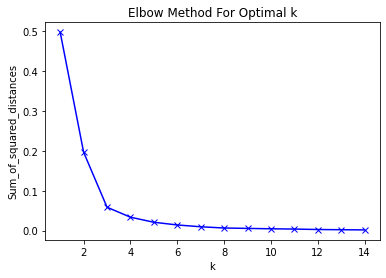

In [302]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [303]:
# set number of clusters as 4
kclusters = 4

kl_clustering = kl_mall.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 3, 1, 1, 2, 2, 2, 2, 1])

In [304]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
kl_merged = kl_mall.copy()

# add clustering labels
kl_merged["Cluster Labels"] = kmeans.labels_

In [305]:
kl_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
kl_merged.head()

Neighborhood    Eatery  Cluster Labels
0         Arekere‎   0.710526               2
1            BEML‎   0.730000               2
2    Banashankari‎   0.500000               3
3       Banaswadi‎   0.877551               1
4    Basavanagudi‎   0.820000               1

In [306]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kl_merged = kl_merged.join(kl_df.set_index("Neighborhood"), on="Neighborhood")

print(kl_merged.shape)
kl_merged.head() # check the last columns!

(55, 5)


Neighborhood    Eatery  Cluster Labels   Latitude  Longitude
0         Arekere‎   0.710526               2  12.885680  77.596680
1            BEML‎   0.730000               2  12.964900  77.592400
2    Banashankari‎   0.500000               3  12.873412  77.538013
3       Banaswadi‎   0.877551               1  13.019644  77.654692
4    Basavanagudi‎   0.820000               1  12.938980  77.571370

In [307]:
# sort the results by Cluster Labels
print(kl_merged.shape)
kl_merged.sort_values(["Cluster Labels"], inplace=True)
kl_merged

(55, 5)


Neighborhood    Eatery  Cluster Labels   Latitude  Longitude
44    Rajarajeshwari Nagar‎   0.657143               0  12.931780  77.526680
23                Ittamadu‎   0.600000               0  12.923440  77.542840
32         Krishnarajapura‎   0.594203               0  13.000390  77.683680
46          Sahakara Nagar‎   0.625000               0  13.061103  77.574092
43             Rajajinagar‎   0.680000               0  13.011920  77.547170
38             Malleswaram‎   0.670000               0  13.006322  77.568416
21                Hosakote‎   0.833333               1  13.077180  77.801780
22             Indiranagar‎   0.830000               1  12.978220  77.633970
24             J. P. Nagar‎   0.800000               1  12.908310  77.590240
26               Jayanagar‎   0.840000               1  12.928720  77.582810
19              HSR Layout‎   0.830189               1  12.910369  77.649301
29               Kodihalli‎   0.830000               1  12.966200  77.649820
30             Konanakunte‎   0.846154               1  12.882330  77.569260
31             Koramangala‎   0.840000               1  12.920040  77.625460
33            Kundalahalli‎   0.809524               1  12.967520  77.715000
34                Madiwala‎   0.810000               1  12.920520  77.620900
41           Murugeshpalya‎   0.875000               1  12.955650  77.653350
40               Mathikere‎   0.812500               1  13.032350  77.558660
27       Jeevanbheemanagar‎   0.810000               1  12.967560  77.655700
55             Yeshwantpur‎   0.794118               1  13.039120  77.577970
39            Marathahalli‎   0.791667               1  12.954660  77.707520
17               Girinagar‎   0.850000               1  12.947163  77.554792
16             Fraser Town‎   0.793814               1  12.998940  77.612760
15        Electronics City‎   0.904762               1  12.839884  77.672211
12             Devanahalli‎   0.833333               1  13.250110  77.707880
53              Whitefield‎   0.818182               1  12.975230  77.752380
9              Bommasandra‎   0.857143               1  12.817530  77.678790
49             Tippasandra‎   0.830000               1  12.971710  77.647800
18              HBR Layout‎   0.823529               1  13.044134  77.626893
51                  Ulsoor‎   0.870000               1  12.989080  77.627950
3                Banaswadi‎   0.877551               1  13.019644  77.654692
4             Basavanagudi‎   0.820000               1  12.938980  77.571370
54               Yelahanka‎   0.722222               2  13.099310  77.592590
50                 UB City‎   0.740000               2  12.971370  77.595820
48            Thubarahalli‎   0.750000               2  12.953500  77.721140
47            Shivajinagar‎   0.730000               2  12.987200  77.604010
52                 Varthur‎   0.705882               2  12.943480  77.747030
0                  Arekere‎   0.710526               2  12.885680  77.596680
28              Kettohalli‎   0.720000               2  12.966180  77.586900
36            Mahadevapura‎   0.695652               2  12.994090  77.666330
25                  Jakkur‎   0.727273               2  13.075640  77.603940
20                  Hebbal‎   0.761905               2  13.049810  77.589030
14                  Domlur‎   0.769231               2  12.943290  77.656020
13               Dhobi Ghat   0.720000               2  12.966180  77.586900
10            Brigade Road‎   0.730000               2  12.966236  77.606791
8                   Bidadi‎   0.720000               2  12.966180  77.586900
7           Bengaluru Pete‎   0.720000               2  12.966180  77.586900
6                Bellandur‎   0.727273               2  12.927350  77.671850
5                    Begur‎   0.750000               2  12.882450  77.624750
1                     BEML‎   0.730000               2  12.964900  77.592400
37                 Majestic   0.740000               2  12.977590  77.572560
56          

**Finally, let's visualize the resulting clusters**

In [318]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow=['#000000' ,'#FF0000', '#00FF00' ,'#0000FF' ]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_merged['Latitude'], kl_merged['Longitude'], kl_merged['Neighborhood'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [309]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

### 8. Examine Clusters

#### Cluster 0

In [310]:
kl_merged.loc[kl_merged['Cluster Labels'] == 0]

Neighborhood    Eatery  Cluster Labels   Latitude  Longitude
44    Rajarajeshwari Nagar‎   0.657143               0  12.931780  77.526680
23                Ittamadu‎   0.600000               0  12.923440  77.542840
32         Krishnarajapura‎   0.594203               0  13.000390  77.683680
46          Sahakara Nagar‎   0.625000               0  13.061103  77.574092
43             Rajajinagar‎   0.680000               0  13.011920  77.547170
38             Malleswaram‎   0.670000               0  13.006322  77.568416

#### Cluster 1

In [311]:
kl_merged.loc[kl_merged['Cluster Labels'] == 1]

Neighborhood    Eatery  Cluster Labels   Latitude  Longitude
21             Hosakote‎   0.833333               1  13.077180  77.801780
22          Indiranagar‎   0.830000               1  12.978220  77.633970
24          J. P. Nagar‎   0.800000               1  12.908310  77.590240
26            Jayanagar‎   0.840000               1  12.928720  77.582810
19           HSR Layout‎   0.830189               1  12.910369  77.649301
29            Kodihalli‎   0.830000               1  12.966200  77.649820
30          Konanakunte‎   0.846154               1  12.882330  77.569260
31          Koramangala‎   0.840000               1  12.920040  77.625460
33         Kundalahalli‎   0.809524               1  12.967520  77.715000
34             Madiwala‎   0.810000               1  12.920520  77.620900
41        Murugeshpalya‎   0.875000               1  12.955650  77.653350
40            Mathikere‎   0.812500               1  13.032350  77.558660
27    Jeevanbheemanagar‎   0.810000               1  12.967560  77.655700
55          Yeshwantpur‎   0.794118               1  13.039120  77.577970
39         Marathahalli‎   0.791667               1  12.954660  77.707520
17            Girinagar‎   0.850000               1  12.947163  77.554792
16          Fraser Town‎   0.793814               1  12.998940  77.612760
15     Electronics City‎   0.904762               1  12.839884  77.672211
12          Devanahalli‎   0.833333               1  13.250110  77.707880
53           Whitefield‎   0.818182               1  12.975230  77.752380
9           Bommasandra‎   0.857143               1  12.817530  77.678790
49          Tippasandra‎   0.830000               1  12.971710  77.647800
18           HBR Layout‎   0.823529               1  13.044134  77.626893
51               Ulsoor‎   0.870000               1  12.989080  77.627950
3             Banaswadi‎   0.877551               1  13.019644  77.654692
4          Basavanagudi‎   0.820000               1  12.938980  77.571370

#### Cluster 2

In [312]:
kl_merged.loc[kl_merged['Cluster Labels'] == 2]

Neighborhood    Eatery  Cluster Labels   Latitude  Longitude
54         Yelahanka‎   0.722222               2  13.099310  77.592590
50           UB City‎   0.740000               2  12.971370  77.595820
48      Thubarahalli‎   0.750000               2  12.953500  77.721140
47      Shivajinagar‎   0.730000               2  12.987200  77.604010
52           Varthur‎   0.705882               2  12.943480  77.747030
0            Arekere‎   0.710526               2  12.885680  77.596680
28        Kettohalli‎   0.720000               2  12.966180  77.586900
36      Mahadevapura‎   0.695652               2  12.994090  77.666330
25            Jakkur‎   0.727273               2  13.075640  77.603940
20            Hebbal‎   0.761905               2  13.049810  77.589030
14            Domlur‎   0.769231               2  12.943290  77.656020
13         Dhobi Ghat   0.720000               2  12.966180  77.586900
10      Brigade Road‎   0.730000               2  12.966236  77.606791
8             Bidadi‎   0.720000               2  12.966180  77.586900
7     Bengaluru Pete‎   0.720000               2  12.966180  77.586900
6          Bellandur‎   0.727273               2  12.927350  77.671850
5              Begur‎   0.750000               2  12.882450  77.624750
1               BEML‎   0.730000               2  12.964900  77.592400
37           Majestic   0.740000               2  12.977590  77.572560
56       Yeswanthpur‎   0.726316               2  13.018644  77.557617

In [313]:
kl_merged.loc[kl_merged['Cluster Labels'] == 3]

Neighborhood    Eatery  Cluster Labels   Latitude  Longitude
42          Nagarbhavi‎   0.461538               3  12.956240  77.509360
45    Ramamurthy Nagar‎   0.500000               3  13.023820  77.677850
2         Banashankari‎   0.500000               3  12.873412  77.538013

#### Observations:
Most of the Eateries are concentrated in the central area of Bangalore city, with the highest number in cluster 1 and moderately high number in cluster 2. Cluster 0 has medium concentration of Eateries.On the other hand, cluster 3 has very low number of Eateries in the neighborhoods. This represents a great opportunity and high potential areas to open new Restaurants as there is very little to no competition from existing Eateries. Meanwhile, Eateries in cluster 1 are likely suffering from intense competition due to oversupply and high concentration.   
From another perspective, this also shows that the oversupply of Eateries mostly happened in the central area of the city, while the suburb area  have very few Eateries. Therefore, this project recommends Entrepreneurs to capitalize on these findings to open new Restaurants in neighborhoods in cluster 3 with little to no competition. 
Entrepreneurs with unique selling propositions to stand out from the competition can also open new Restaurants in neighborhoods in cluster 0 or cluster 2 with moderate competition. 
Lastly, Entrepreneurs are advised to avoid neighborhoods in cluster 2 which already have high concentration of Eateries and suffering from intense competition.